# Transfer Learning for Computer Vision 

https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## 전이학습의 주요한 2가지 기능

- **합성곱 신경망의 미세조정(finetuning)**: 무작위 초기화 대신, 신경망을 ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지 과정들은 평상시와 같습니다.


- **고정된 특징 추출기로써의 합성곱 신경망**: 여기서는 마지막에 완전히 연결 된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [6]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

- transforms를 활용해서 image 를 Transformations를 가능하게 함.
- torchvision의 transforms의 Compose를 사용, 각각의 변환을 Chain으로 연결가능

`torchvision.transforms.RandomResizedCrop`

input image or tensor에 대해 랜덤하게 자르거나 가로세율 비율로 자른다
![image.png](1.png)

위의 코드에선 224이므로 224*224로 잘리고 나머진 default값임

`transforms.RandomHorizontalFlip`

가로로 뒤집는 것 Default 는 0.5

`transforms.ToTensor`
PIL image나 numpy.ndarray를 tensor로 변경하는 것.

(C * H * W)형태로 변환

`transforms.Normalize` 평균과 표준편자를 통해 Normalize하는 것
![image-2.png](2.png)

In [8]:
print(type(data_transforms))
print()
print(data_transforms)

<class 'dict'>

{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [10]:
data_dir = 'hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [11]:
print(type(image_datasets))
print()
print(image_datasets)
print()
print(image_datasets['train'])

<class 'dict'>

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224),

`torchvision.datasets.ImageFolder`
root 와 Datatransforms뭐 해줄건지 정해주는 것

In [12]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

`torch.utils.data.DataLoader`

데이터 뽑아주는거 , batch_size와 shuffle을 통해 특성잡아 뽑아주고 num_workers가

CPU를 얼마나 쓸껀지 높을수록 많이씀

In [13]:
print(type(dataloaders))
print()
print(dataloaders)
print()
print(dataloaders['train'])

<class 'dict'>

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f88019ffdf0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f88019ffc10>}



In [17]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(type(dataset_sizes),end='\n\n')
print(dataset_sizes,end='\n\n')
print(dataset_sizes['train'])

<class 'dict'>

{'train': 244, 'val': 153}

244


In [20]:
class_names = image_datasets['train'].classes
print(type(class_names))
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(type(device))
print(device)

<class 'list'>
['ants', 'bees']
<class 'torch.device'>
cuda:0


## 일부 이미지 시각화

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

np.clip(배열 , 최소값 , 최대값) 최소보다 작으면 최소로 최대보다 크면 최대로

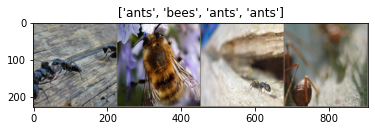

In [23]:
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
print(inputs.shape)
print(type(inputs))

torch.Size([4, 3, 224, 224])
<class 'torch.Tensor'>


## 모델 학습하기
- learning rate scheduling
- optimize model

아래에서 scheduler 매개변수는 torch.optim.lr_scheduler 의 LR 스케쥴러 객체(Object)입니다.

In [32]:
# model-> model , criterion -> loss function(Cross-Entropy), optimizer -> SGD , sheduler ->LR sheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #현재 시간 받아오기
    since = time.time()
    
    #model.state_dict()는 OrderedDict으로 model의 다양한 정보가 있음
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [34]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [31]:
print(type(model_ft.state_dict()))

<class 'collections.OrderedDict'>


In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8032 Acc: 0.6475
val Loss: 0.7178 Acc: 0.7516

Epoch 1/24
----------
train Loss: 1.1824 Acc: 0.6557
val Loss: 0.6333 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.9716 Acc: 0.7377
val Loss: 0.4730 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.6381 Acc: 0.7459
val Loss: 0.3990 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.6372 Acc: 0.7746
val Loss: 0.3553 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.4806 Acc: 0.8402
val Loss: 0.4012 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.4810 Acc: 0.8320
val Loss: 0.3180 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3730 Acc: 0.8525
val Loss: 0.2452 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.4172 Acc: 0.8320
val Loss: 0.2127 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2489 Acc: 0.8893
val Loss: 0.1881 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3283 Acc: 0.8525
val Loss: 0.1869 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2950 Acc: 0.8689
val Loss: 0.1852 Acc: 0.9477

Ep

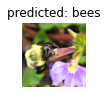

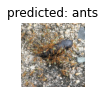

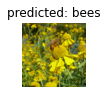

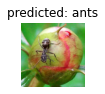

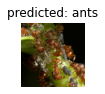

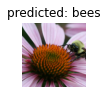

In [36]:
visualize_model(model_ft)

In [37]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [38]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6872 Acc: 0.6393
val Loss: 0.2647 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4484 Acc: 0.7992
val Loss: 0.3491 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.4650 Acc: 0.7910
val Loss: 0.1926 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5099 Acc: 0.7541
val Loss: 0.5112 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.3695 Acc: 0.8484
val Loss: 0.1761 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3943 Acc: 0.8525
val Loss: 0.1820 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4945 Acc: 0.8033
val Loss: 0.2111 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2255 Acc: 0.8975
val Loss: 0.2017 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4113 Acc: 0.8156
val Loss: 0.1925 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3651 Acc: 0.8443
val Loss: 0.2322 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4022 Acc: 0.8320
val Loss: 0.2361 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3376 Acc: 0.8607
val Loss: 0.2118 Acc: 0.9542

Ep

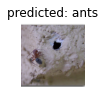

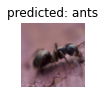

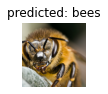

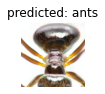

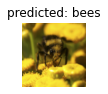

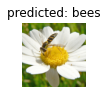

In [39]:
visualize_model(model_conv)

plt.ioff()
plt.show()